Michael Muschitiello // Interest Rate Derivatives

- This Jupyter Notebook fetches yield data for various maturities from FRED, manipulates and cleans the data, bootstraps discount factors and zero rates, then applies interpolation (piecewise flat and quadratic spline) to generate and plot a smooth yield curve.

In [12]:
import numpy as np 
import pandas as pd 
import fredapi as Fred 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from fredapi import Fred
API_KEY = "9da7edac51a3a1adab2418a20abb4d0d"
# Initialize FRED API
fred = Fred(api_key=API_KEY)

In [3]:
cmt_series_ids = {
    "1m": "DGS1MO",
    "3m": "DGS3MO",
    "6m": "DGS6MO",
    "1y": "DGS1",
    "2y": "DGS2",
    "3y": "DGS3",
    "5y": "DGS5",
    "7y": "DGS7",
    "10y": "DGS10",
    "20y": "DGS20",
    "30y": "DGS30"
}

cmts_df = pd.DataFrame()
for maturity, series_id in cmt_series_ids.items():
    cmts_df[maturity] = fred.get_series(series_id)

cmts_df.tail()

,1m,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y
2025-01-27,4.44,4.32,4.25,4.13,4.17,4.24,4.32,4.43,4.53,4.82,4.76
2025-01-28,4.44,4.31,4.26,4.14,4.19,4.25,4.33,4.43,4.55,4.84,4.78
2025-01-29,4.43,4.31,4.27,4.17,4.21,4.27,4.35,4.44,4.55,4.85,4.79
2025-01-30,4.37,4.30,4.27,4.16,4.18,4.24,4.31,4.41,4.52,4.81,4.76
2025-01-31,4.37,4.31,4.28,4.17,4.22,4.27,4.36,4.47,4.58,4.88,4.83


In [4]:
latest_cmts = cmts_df.iloc[-1]
# not using 1m, 3m 
latest_cmts = latest_cmts[2:]
latest_cmts

6m     4.28
1y     4.17
2y     4.22
3y     4.27
5y     4.36
7y     4.47
10y    4.58
20y    4.88
30y    4.83
Name: 2025-01-31 00:00:00, dtype: float64

In [5]:
latest_cmts_df = pd.DataFrame(latest_cmts)
#latest_cmts_df['2025-01-30'] = latest_cmts_df['2025-01-30']/100
latest_cmts_df

,2025-01-31
6m,4.28
1y,4.17
2y,4.22
3y,4.27
5y,4.36
7y,4.47
10y,4.58
20y,4.88
30y,4.83


In [6]:
latest_cmts_df['2025-01-31'] = latest_cmts_df['2025-01-31']/100
latest_cmts_df

,2025-01-31
6m,0.0428
1y,0.0417
2y,0.0422
3y,0.0427
5y,0.0436
7y,0.0447
10y,0.0458
20y,0.0488
30y,0.0483


In [7]:
latest_cmts_df.index

Index(['6m', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y'], dtype='object')

In [8]:
# parse the index to convert maturity  obj to float in years
def parse_maturity(m):
    if m.endswith("m"):
        return float(m[:-1]) / 12
    elif m.endswith("y"):
        return float(m[:-1])
    return None

latest_cmts_df.index = latest_cmts_df.index.map(parse_maturity)
latest_cmts_df

,2025-01-31
0.5,0.0428
1.0,0.0417
2.0,0.0422
3.0,0.0427
5.0,0.0436
7.0,0.0447
10.0,0.0458
20.0,0.0488
30.0,0.0483


In [9]:
latest_cmts_df.reset_index(inplace=True)
latest_cmts_df.columns = ['maturity', 'yield']
latest_cmts_df

,maturity,yield
0,0.5,0.0428
1,1.0,0.0417
2,2.0,0.0422
3,3.0,0.0427
4,5.0,0.0436
5,7.0,0.0447
6,10.0,0.0458
7,20.0,0.0488
8,30.0,0.0483


### Bootstrapping Discount Factors and Discount Rates

We compute the discount factors \( D_i \) and discount rates \( r_i \) given constant maturity yields \( y_i \) and times to maturity \( T_i \).

#### **1. Initial Discount Factor:**
$$
D_0 = \frac{1}{1 + y_0 T_0}
$$

#### **2. Subsequent Discount Factors (Piecewise-Flat Assumption):**
For \( i = 1, 2, ..., n \):

$$
D_i = \frac{D_{i-1}}{1 + y_i (T_i - T_{i-1})}
$$

#### **3. Computing Discount Rates:**
The continuously compounded discount rate \( r_i \) is given by:

$$
r_i = -\frac{\ln D_i}{T_i}
$$


In [10]:
# pull the values from cmts dataframe
maturities = latest_cmts_df['maturity'].values
yields = latest_cmts_df['yield'].values

# fill in intermediate maturities
new_maturities = np.arange(0.5, maturities[-1] + 0.5, 0.5)

# initialize the discount factors
discount_factors = np.zeros_like(new_maturities)
discount_factors[0] = 1 / (1 + yields[0] * new_maturities[0])

# initialize the yields
new_yields = np.zeros_like(new_maturities)
new_yields[0] = yields[0]

# compute discount factors and yields using piecewise-flat assumption
for i in range(1, len(new_maturities)):
    # Find the closest original maturity less than or equal to the current new maturity
    closest_maturity_index = np.searchsorted(maturities, new_maturities[i], side='right') - 1
    closest_yield = yields[closest_maturity_index]
    new_yields[i] = closest_yield
    discount_factors[i] = discount_factors[i-1] / (1 + closest_yield * (new_maturities[i] - new_maturities[i-1]))

# compute discount rates
discount_rates = -np.log(discount_factors) / new_maturities

results_df = pd.DataFrame({
    'maturity': new_maturities,
    'yield': new_yields,
    'discount_factor': discount_factors,
    'discount_rate': discount_rates
})

print(results_df)

    maturity   yield  discount_factor  discount_rate
0        0.5  0.0428         0.979048       0.042348
1        1.0  0.0417         0.959052       0.041810
2        1.5  0.0417         0.939464       0.041630
3        2.0  0.0422         0.920051       0.041663
4        2.5  0.0422         0.901039       0.041683
5        3.0  0.0427         0.882204       0.041777
6        3.5  0.0427         0.863763       0.041845
7        4.0  0.0427         0.845707       0.041896
8        4.5  0.0427         0.828029       0.041935
9        5.0  0.0436         0.810363       0.042055
10       5.5  0.0436         0.793074       0.042153
11       6.0  0.0436         0.776154       0.042234
12       6.5  0.0436         0.759594       0.042303
13       7.0  0.0447         0.742989       0.042439
14       7.5  0.0447         0.726746       0.042557
15       8.0  0.0447         0.710858       0.042660
16       8.5  0.0447         0.695318       0.042751
17       9.0  0.0447         0.680117       0.

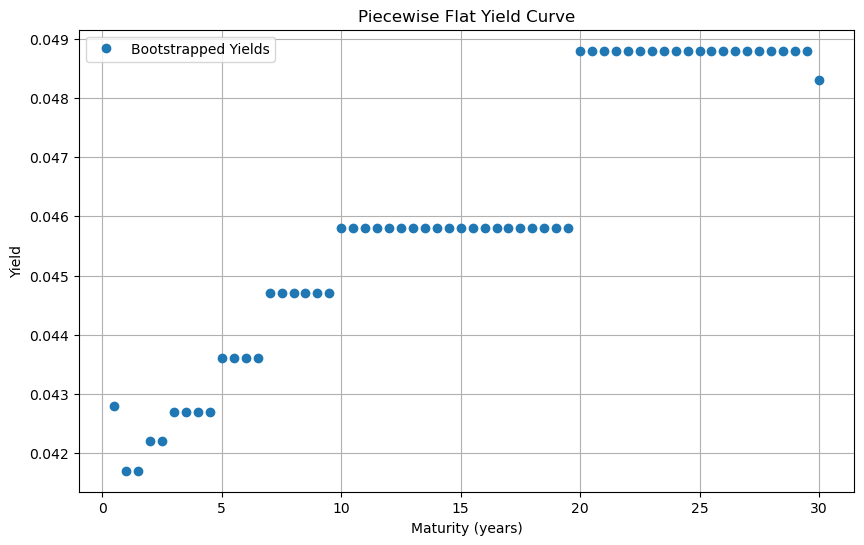

In [13]:
# plotting original yields and quadratically interpolated curve
plt.figure(figsize=(10, 6))
plt.plot(new_maturities, new_yields, 'o', label='Bootstrapped Yields')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Piecewise Flat Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

## Use hypothetical 11 key forward rates and perform a quadratic spline curve fitting

### Quadratic Spline for Yield Curve Interpolation

The quadratic spline interpolation for yield curves is given by:

$$
y(\tau) = a_i + b_i (\tau - \tau_i) + c_i (\tau - \tau_i)^2 
$$

where:

- $( y(\tau) )$ is the interpolated yield at maturity \( \tau \).
- $( a_i, b_i, c_i, d_i )$ are the spline coefficients for the segment between $( \tau_i)$ and $( \tau_{i+1})$.
- $( \tau )$ is the target maturity at which the yield is interpolated.
- $( \tau_i )$ is the closest known maturity point to \( \tau \).
- The cubic term ensures smoothness in the yield curve.

This approach provides a smooth transition between yield curve points while maintaining continuity in the first and second derivatives.


In [14]:
eleven_rates = cmts_df.iloc[-1]
eleven_rates

1m     4.37
3m     4.31
6m     4.28
1y     4.17
2y     4.22
3y     4.27
5y     4.36
7y     4.47
10y    4.58
20y    4.88
30y    4.83
Name: 2025-01-31 00:00:00, dtype: float64

In [15]:
eleven_rates = pd.DataFrame(eleven_rates)
eleven_rates['2025-01-31'] = eleven_rates['2025-01-31']/100
eleven_rates

,2025-01-31
1m,0.0437
3m,0.0431
6m,0.0428
1y,0.0417
2y,0.0422
3y,0.0427
5y,0.0436
7y,0.0447
10y,0.0458
20y,0.0488


In [16]:
eleven_rates.index = eleven_rates.index.map(parse_maturity)
eleven_rates.reset_index(inplace=True)
eleven_rates.columns = ['maturity', 'yield']
eleven_rates

,maturity,yield
0,0.083333,0.0437
1,0.250000,0.0431
2,0.500000,0.0428
3,1.000000,0.0417
4,2.000000,0.0422
5,3.000000,0.0427
6,5.000000,0.0436
7,7.000000,0.0447
8,10.000000,0.0458
9,20.000000,0.0488


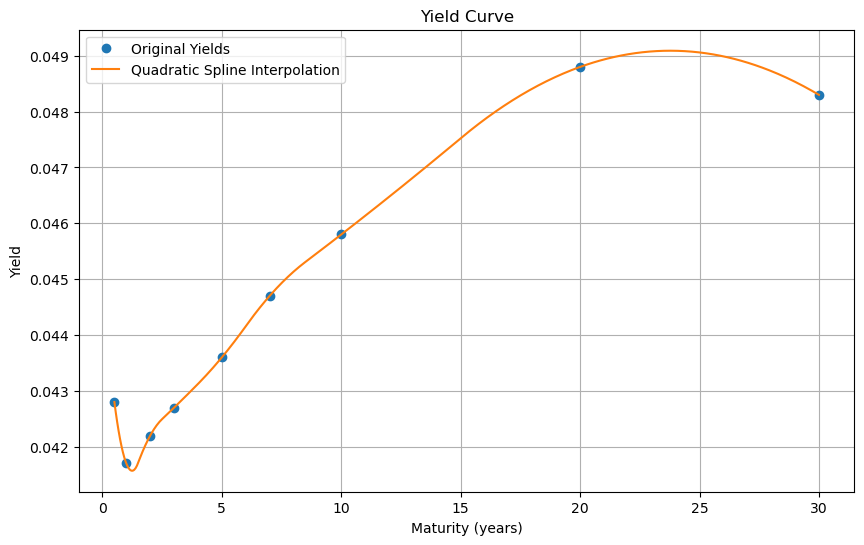

In [17]:
# np.linspace to get a continuous range of maturities
continuous_maturities = np.linspace(maturities.min(), maturities.max(), 500)

# quadratic spline interpolation
quadratic_spline = interp1d(maturities, yields, kind='quadratic')
smooth_yields = quadratic_spline(continuous_maturities)

# plotting original yields and quadratically interpolated curve
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields, 'o', label='Original Yields')
plt.plot(continuous_maturities, smooth_yields, '-', label='Quadratic Spline Interpolation')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Yield Curve')
plt.legend()
plt.grid(True)
plt.show()